## Machine learning for forecasting


In order to apply machine learning models to forecasting problems, the time series has to be transformed into a matrix in which each value is related to the time window (lags) that precedes it.

In a time series context, a lag with respect to a time step  $𝑡$
  is defined as the values of the series at previous time steps. For example, lag 1 is the value at time step  $𝑡−1$
  and lag  $𝑚$
  is the value at time step  $𝑡−𝑚$
 .
This type of transformation also allows to include additional variables.

Once data have been rearranged into the new shape, any regression model can be trained to predict the next value (step) of the series. During model training, every row is considered a separate data instance, where values at lags 1, 2, ...  $𝑝$
  are considered predictors for the target quantity of the time series at time step  $𝑝+1$
 .

## Multi-Step Time Series Forecasting


When working with time series, it is seldom needed to predict only the next element in the series ( $𝑡+1$
 ). Instead, the most common goal is to predict a whole future interval (( $𝑡+1$
 ), ..., ( $𝑡+𝑛$
 )) or a far point in time ( $𝑡+𝑛$
 ). Several strategies allow generating this type of prediction.

## Recursive multi-step forecasting


Since the value  $𝑡𝑛−1$
  is required to predict  $𝑡𝑛$
 , and  $𝑡𝑛−1$
  is unknown, a recursive process is applied in which, each new prediction, is based on the previous one. This process is known as recursive forecasting or recursive multi-step forecasting and can be easily generated with the ForecasterAutoreg and ForecasterAutoregCustom classes.

## Direct multi-step forecasting
Direct multi-step forecasting consists of training a different model for each step of the forecast horizon. For example, to predict the next 5 values of a time series, 5 different models are trained, one for each step. As a result, the predictions are independent of each other.

The main complexity of this approach is to generate the correct training matrices for each model. The ForecasterAutoregDirect class of the skforecast library automates this process. It is also important to bear in mind that this strategy has a higher computational cost since it requires the train of multiple models. The following diagram shows the process for a case in which the response variable and two exogenous variables are available.


## Multiple output forecasting


Some machine learning models, such as long short-term memory (LSTM) neural network, can predict simultaneously several values of a sequence (one-shot). This strategy is not currently implemented in skforecast library.


## Recursive autoregressive forecasting


A time series is available with the monthly expenditure (millions of dollars) on corticosteroid drugs that the Australian health system had between 1991 and 2008. It is intended to create an autoregressive model capable of predicting future monthly expenditures.

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [3]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')
data.head()

,fecha,y,exog_1,exog_2
0,1992-04-01,0.379808,0.958792,1.166029
1,1992-05-01,0.361801,0.951993,1.117859
2,1992-06-01,0.410534,0.952955,1.067942
3,1992-07-01,0.483389,0.958078,1.097376
4,1992-08-01,0.475463,0.956370,1.122199


In [4]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


In [5]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [6]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


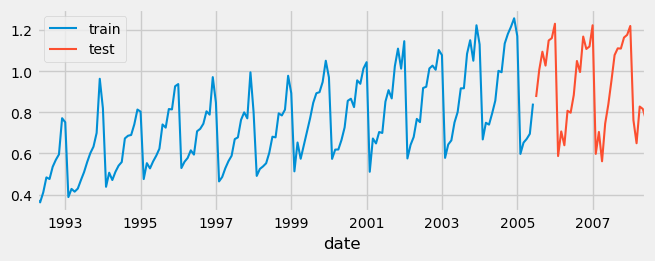

In [9]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend()
plt.show()

## ForecasterAutoreg


With the ForecasterAutoreg class, a model is created and trained from a RandomForestRegressor regressor with a time window of 6 lags. This means that the model uses the previous 6 months as predictors.

In [10]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-07-04 16:51:57 
Last fit date: 2023-07-04 16:51:57 
Skforecast version: 0.8.1 
Python version: 3.8.8 
Forecaster id: None 

In [11]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

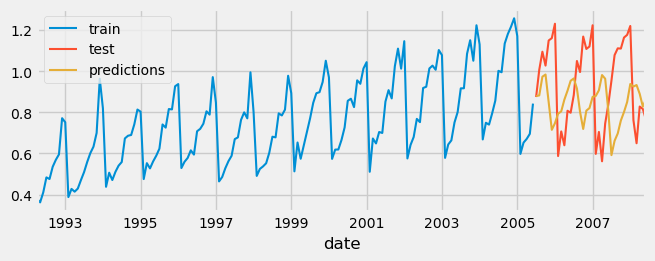

In [15]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

In [16]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.07326833976120374


## Hyperparameter tuning


The trained ForecasterAutoreg uses a 6 lag time window and a Random Forest model with the default hyperparameters. However, there is no reason why these values are the most suitable. In order to identify the best combination of lags and hyperparameters, the Skforecast library provides the grid_search_forecaster function. It compares the results obtained with each model configuration.

In [17]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.012836389345193383



In [18]:
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.012836,3,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.012858,3,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.013248,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.013364,5,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.013435,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.014028,10,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.036982,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.037345,3,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",0.037574,5,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",0.040542,10,500


In [19]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['y'])

In [20]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

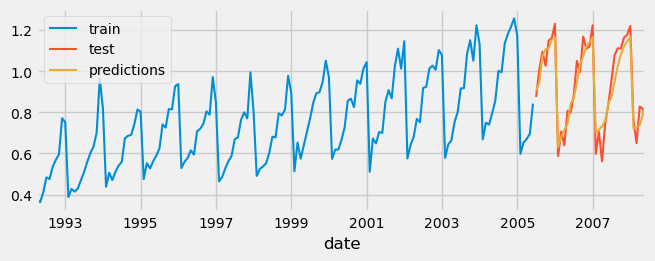

In [21]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

In [22]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.004392699665157793


## Backtesting
Backtesting is a term used in modeling to refer to testing a predictive model on historical data. Backtesting involves moving backward in time, step-by-step, in as many stages as is necessary. Therefore, it is a special type of cross-validation applied to previous period(s).

### Backtesting with refit and increasing training size (fixed origin)

The model is trained each time before making predictions. With this configuration, the model uses all the data available so far. It is a variation of the standard cross-validation but, instead of making a random distribution of the observations, the training set increases sequentially, maintaining the temporal order of the data.

### Backtesting with refit and fixed training size (rolling origin)

A technique similar to the previous one but, in this case, the forecast origin rolls forward, therefore, the size of training remains constant. This is also known as time series cross-validation or walk-forward validation.

### Backtesting without refit

After an initial train, the model is used sequentially without updating it and following the temporal order of the data. This strategy has the advantage of being much faster since the model is trained only once. However, the model does not incorporate the latest data available, so it may lose predictive capacity over time.

The skforecast library has the mentioned backtesting strategies implemented. Regardless of which one is used, it is important not to include test data in the search process to avoid overfitting problems.

For this example, a backtesting with refit strategy is followed. Internally, the process that the function applies is:

* In the first iteration, the model is trained with the observations selected for the initial training (in this case, 87). Then, the next 36 observations are used to validate the predictions of this first model.

* In the second iteration, the model is retrained by adding, to the initial training set, the previous 36 validation observations (87 + 36). In the same way, the next 36 observations are established as the new validation set.

* This process is repeated until all available observations are used. Following this strategy, the training set increases in each iteration with as many observations as steps are being predicted.

In [23]:
# Backtesting
# ==============================================================================
steps = 36
n_backtesting = 36*3 # The last 9 years are separated for the backtest

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = data['y'],
                                    initial_train_size = len(data) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    metric             = 'mean_squared_error',
                                    refit              = True,
                                    verbose            = True,
                                    show_progress      = True
                                )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

Backtest error: 0.010578977232387663


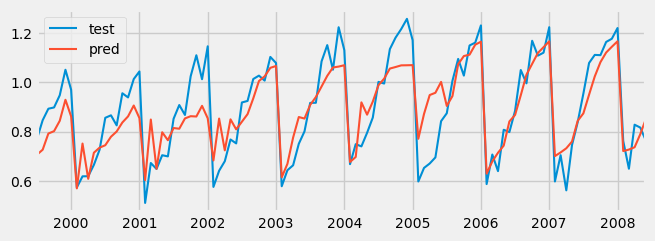

In [26]:
# Plot backtest predictions vs real values
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[predictions_backtest.index, 'y'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

In [27]:
# Predictors importances
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.009412
1,lag_2,0.087268
2,lag_3,0.012754
3,lag_4,0.001446
4,lag_5,0.000401
5,lag_6,0.001386
6,lag_7,0.001273
7,lag_8,0.006926
8,lag_9,0.005839
9,lag_10,0.013076


## Recursive autoregressive forecasting with exogenous variables

In the previous example, only lags of the predicted variable itself have been used as predictors. In certain scenarios, it is possible to have information about other variables, whose future value is known, so could serve as additional predictors in the model.

Continuing with the previous example, a new variable whose behavior is correlated with the modeled time series and it is wanted to incorporate as a predictor is simulated. The same applies to multiple exogenous variables.

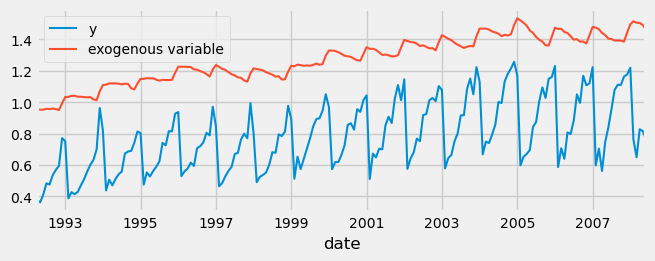

In [28]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')

# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

fig, ax = plt.subplots(figsize=(7, 2.5))
data['y'].plot(ax=ax, label='y')
data['exog_1'].plot(ax=ax, label='exogenous variable')
ax.legend()
plt.show()

In [29]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [30]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=data_train['y'], exog=data_train['exog_1'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog_1 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-07-04 17:17:20 
Last fit date: 2023-07-04 17:17:21 
Skforecast version: 0.8.1 
Python ver

In [31]:
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

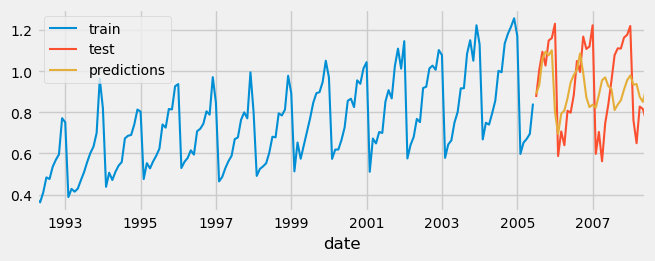

In [32]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

In [33]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.03989087922533575


In [34]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['y'],
                    exog        = data_train['exog_1'],
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    steps       = steps,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    return_best = True,
                    verbose     = False
               )

Number of models compared: 27.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 10, 'n_estimators': 50}
  Backtesting metric: 0.007172428407773492



In [35]:
results_grid.head()

,lags,params,mean_squared_error,max_depth,n_estimators
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 50}",0.007172,10,50
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 100}",0.007176,10,100
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 500}",0.007535,10,500
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 500}",0.007960,5,500
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 100}",0.008168,5,100


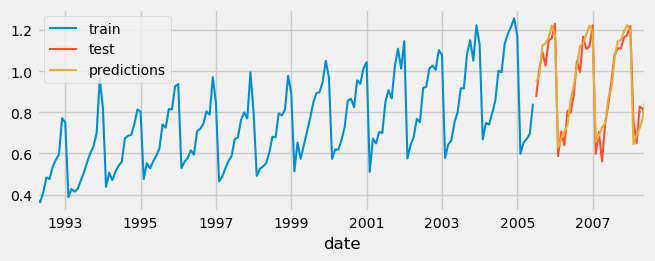

In [36]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

In [37]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 0.0044949967759907675


## Recursive autoregressive forecasting with custom predictors


In addition to the lags, it may be interesting to incorporate other characteristics of the time series in some scenarios. For example, the moving average of the last n values could be used to capture the series's trend.

The ForecasterAutoregCustom class behaves very similar to the ForecasterAutoreg class seen in the previous sections, but with the difference that it is the user who defines the function used to create the predictors.

The first example of the document about predicting the last 36 months of the time series is repeated. In this case, the predictors are the first 10 lags and the values' moving average of the lasts 20 months.

In [38]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')

# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [39]:
# Function to calculate predictors from time series
# ==============================================================================
def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors

In [40]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: custom_predictors 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-07-04 17:26:02 
Last fit date: 2023-07-04 17:26:03 
Skforecast version: 0.8.1 
Python 

In [41]:
print(forecaster.source_code_fun_predictors)


def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors



In [42]:
X, y = forecaster.create_train_X_y(y=data_train['y'])
X.head(4)

,custom_predictor_0,custom_predictor_1,custom_predictor_2,custom_predictor_3,custom_predictor_4,custom_predictor_5,custom_predictor_6,custom_predictor_7,custom_predictor_8,custom_predictor_9,custom_predictor_10
date,,,,,,,,,,,
1993-12-01,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.427283,0.387554,0.523089
1994-01-01,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.427283,0.552253
1994-02-01,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.575129
1994-03-01,0.437670,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.576486


In [43]:
y.head(4)

date
1993-12-01    0.963081
1994-01-01    0.819325
1994-02-01    0.437670
1994-03-01    0.506121
Freq: MS, Name: y, dtype: float64

In [44]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)

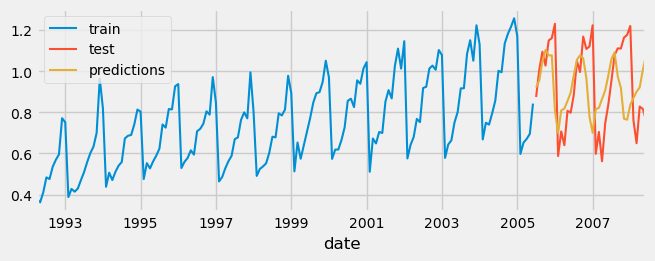

In [45]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

In [46]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.046232546768232


In [47]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['y'],
                    param_grid  = param_grid,
                    steps       = steps,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    fixed_train_size   = False,
                    return_best = True,
                    verbose     = False
               )

Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: custom predictors 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.03431493238511672



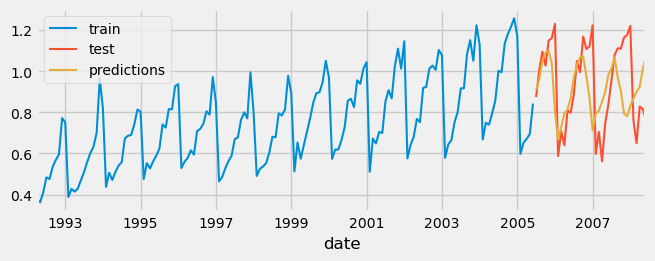

In [48]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

In [49]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 0.04194326997422299


## Direct multi-step forecasting


The ForecasterAutoreg and ForecasterAutoregCustom models follow a recursive prediction strategy in which each new prediction builds on the previous one. An alternative is to train a model for each of the steps to be predicted. This strategy, commonly known as direct multi-step forecasting, is computationally more expensive than recursive since it requires training several models. However, in some scenarios, it achieves better results. These kinds of models can be obtained with the ForecasterAutoregDirect class and can include one or multiple exogenous variables.


### ForecasterAutoregDirect


Unlike when using ForecasterAutoreg or ForecasterAutoregCustom, the number of steps to be predicted must be indicated in the ForecasterAutoregDirect type models. This means that the number of predictions obtained when executing the predict() method is always the same. It is not possible to predict steps beyond the value defined at their creation.

For this example, a linear model with Lasso penalty is used as a regressor. These models require the predictors to be standardized, so it is combined with a StandardScaler.

For more detailed documentation how to use transformers and pipelines, visit: skforecast with scikit-learn and transformers pipelines.

In [50]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8
             )

forecaster

ForecasterAutoregDirect 
Regressor: Lasso(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 8 
Maximum steps predicted: 36 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': 123, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-07-04 17:36:23 
Last fit date: None 
Skforecast version: 0.8.1 
Python version: 3.8.8 
Forecaster id: None 

In [51]:
# Hyperparameter Grid search
# ==============================================================================
from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8 # This value will be replaced in the grid search
             )

param_grid = {'alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = data_train['y'],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = 36,
                    refit              = True,
                    metric             = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    fixed_train_size   = False,
                    return_best        = True,
                    verbose            = False
                )

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 0.021544346900318846}
  Backtesting metric: 0.01309677527145483



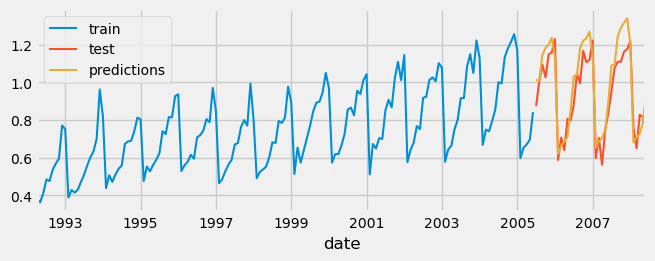

In [53]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

In [54]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 0.010777156130592202
